In [1]:
# !pip install geoopt
# !pip install pyriemann
# !pip install pot

In [3]:
import torch
import ot
import geoopt
# import scipy.linalg
import sys

import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.distributions as D

from tqdm.auto import trange
from geoopt import linalg
from pyriemann.datasets import sample_gaussian_spd, generate_random_spd_matrix

sys.path.append("./lib")
from swspd import *
from utils_spd import busemann_spd
# from logm import logm

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Busemann

In [7]:
theta = torch.randn(1000, 2).to(device)
theta = theta/torch.sqrt(torch.sum(theta**2, axis=-1))[:,None]
A = theta[:,None] * torch.eye(theta.shape[-1], device=device)
    
## Preprocessing to compute the matrix product using a simple product
diagA = torch.diagonal(A, dim1=-2, dim2=-1)
dA = diagA.unsqueeze(-1)
dA = dA.repeat(1,1,2)

In [8]:
M = torch.eye(2, device=device)
M = M.reshape((1, 2, 2))
M = M.repeat(10, 1, 1)

## Compute logM in advance since we cannot batch it
# log_M = torch.zeros(M.shape, device=device)
# for k in range(len(log_M)):
#     log_M[k] = logm(M[k])
log_M = linalg.sym_logm(M)

In [9]:
b = busemann_spd(log_M, dA)

In [10]:
print(log_M.shape, dA.shape)
print(b.shape)

torch.Size([10, 2, 2]) torch.Size([1000, 2, 2])
torch.Size([10, 1000])


In [11]:
b

tensor([[-0., -0., -0.,  ..., -0., -0., -0.],
        [-0., -0., -0.,  ..., -0., -0., -0.],
        [-0., -0., -0.,  ..., -0., -0., -0.],
        ...,
        [-0., -0., -0.,  ..., -0., -0., -0.],
        [-0., -0., -0.,  ..., -0., -0., -0.],
        [-0., -0., -0.,  ..., -0., -0., -0.]], device='cuda:0')

In [12]:
ts = torch.linspace(-10,10,200).to(device)
ts = ts.reshape(ts.shape[0],1,1)
ts = ts.repeat(1,2,2)

In [18]:
theta = torch.randn(3, 2).to(device)
theta = theta/torch.sqrt(torch.sum(theta**2, axis=-1))[:,None]
A = theta[:,None] * torch.eye(theta.shape[-1], device=device)
    
## Preprocessing to compute the matrix product using a simple product
diagA = torch.diagonal(A, dim1=-2, dim2=-1)
dA = diagA.unsqueeze(-1)
dA = dA.repeat(1,1,2)

In [19]:
M = torch.linalg.matrix_exp(ts[:,None]*A[None])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: An output with one or more elements was resized since it had shape [6, 2, 2], which does not match the required output shape [1, 6, 2, 2]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:17.)
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: An output with one or more elements was resized since it had shape [34, 2, 2], which does not match the required output shape [1, 34, 2, 2]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Tri

In [20]:
print(ts.shape, A.shape, M.shape)

torch.Size([200, 2, 2]) torch.Size([3, 2, 2]) torch.Size([200, 3, 2, 2])


In [21]:
L = np.zeros((ts.shape[0],M.shape[1],A.shape[0]))

for i, t in enumerate(ts):
    # log_M = torch.zeros(M[i].shape, device=device)
    # for k in range(len(log_M)):
    #     log_M[k] = logm(M[i][k])
    
    log_M = linalg.sym_logm(M[i])
    b = busemann_spd(log_M, dA)
    L[i] = b.detach().cpu()

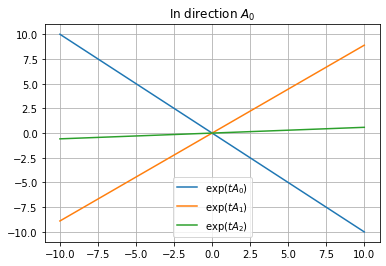

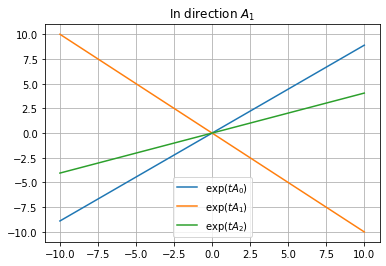

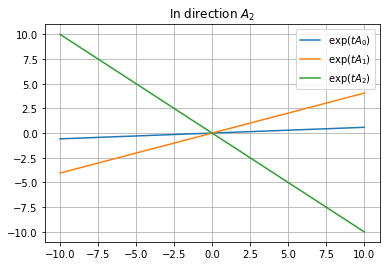

In [22]:
for i in range(A.shape[0]):
    for k in range(3):
        plt.plot(ts[:,0,0].cpu(), L[:,k,i], label=r"$\exp(t A_"+str(k)+r")$")
    plt.title(r"In direction $A_"+str(i)+r"$")
    plt.legend()
    plt.grid(True)
    plt.show()

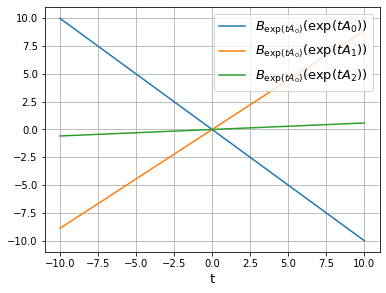

In [36]:
i = 0

fig = plt.figure(figsize=(6,4.5))

for k in range(3):
    plt.plot(ts[:,0,0].cpu(), L[:,k,i], label=r"$B_{\exp(tA_0)}(\exp(t A_"+str(k)+r"))$")

plt.xlabel("t", fontsize=13)
# plt.title(r"In direction $A_"+str(i)+r"$", fontsize=13)
plt.legend(fontsize=13, loc="upper right")
plt.grid(True)
plt.savefig("./Busemann_along_geodesics.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Sliced-Wasserstein

In [37]:
X0 = M[:,0]
X1 = M[:,1]

In [38]:
sw = sliced_wasserstein_spd(X0, X1, 500, device=device).item()
sw

3.099759101867676

In [39]:
X0 = M[:,0]
X1 = M[:,0]

sw = sliced_wasserstein_spd(X0, X1, 500, device=device).item()
sw

0.0

#### Test Wishart Distribution

In [40]:
m0 = D.Wishart(torch.tensor([2], dtype=torch.float64).to(device), torch.eye(2, dtype=torch.float64, device=device))

In [41]:
B0 = m0.sample((100,))[:,0]

/usr/local/lib/python3.7/dist-packages/torch/distributions/wishart.py:247: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


In [42]:
B0.shape

torch.Size([100, 2, 2])

In [43]:
sw = sliced_wasserstein_spd(X0, B0, 500, device=device).item()
sw

8.302459044531298

In [82]:
ntry = 20
nsamples = 500
nprojs = 500

ts = torch.linspace(0.1,10,100)
L_sw_wishart = np.zeros((ntry, len(ts)))

bar = trange(ntry)
for k in bar:
    # pbar = trange(len(ts))
    pbar = range(len(ts))
    for i in pbar:
        t = ts[i]
        mt = D.Wishart(torch.tensor([2], dtype=torch.float64).to(device), t*torch.eye(2, dtype=torch.float64, device=device))
        B0 = m0.sample((nsamples,))[:,0]
        Bt = mt.sample((nsamples,))[:,0]

        sw = sliced_wasserstein_spd(B0, Bt, nprojs, device=device).item()
        L_sw_wishart[k, i] = sw

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/distributions/wishart.py:247: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


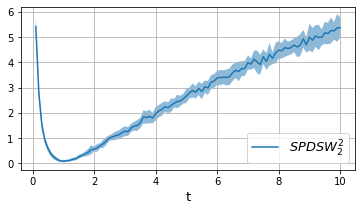

In [83]:
m = np.mean(L_sw_wishart, axis=0)
s = np.std(L_sw_wishart, axis=0)

plt.figure(figsize=(6,3))

plt.plot(ts, m, label=r"$SPDSW_2^2$")
plt.fill_between(ts, m-s, m+s, alpha=0.5)
plt.xlabel("t", fontsize=13)
plt.legend(fontsize=13)
plt.grid(True)
plt.savefig("./SW_Wishart.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
mt = D.Wishart(torch.tensor([2], dtype=torch.float64, device=device), torch.eye(2, dtype=torch.float64, device=device))
B0 = m0.sample((10000,))[:,0]
Bt = mt.sample((10000,))[:,0]

sw = sliced_wasserstein_spd(B0, Bt, 500, device=device).item()
sw

/usr/local/lib/python3.7/dist-packages/torch/distributions/wishart.py:247: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


0.005485481996449547

In [ ]:
ntry = 20
nsamples = 500
nprojs = 500

ts = torch.linspace(1.1,10,200)
L = np.zeros((ntry, len(ts)))

bar = trange(ntry)
for k in bar:
    pbar = range(len(ts))

    for i in pbar:
        t = ts[i]
        mt = D.Wishart(t*torch.tensor([1], dtype=torch.float64, device=device), torch.eye(2, dtype=torch.float64, device=device))
        B0 = m0.sample((nsamples,))[:,0]
        Bt = mt.sample((nsamples,))[:,0]
        
        sw = sliced_wasserstein_spd(B0, Bt, nprojs, device=device).item()
        L[k, i] = sw
    

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/distributions/wishart.py:101: UserWarning: Low df values detected. Singular samples are highly likely to occur for ndim - 1 < df < ndim.
  warnings.warn("Low df values detected. Singular samples are highly likely to occur for ndim - 1 < df < ndim.")


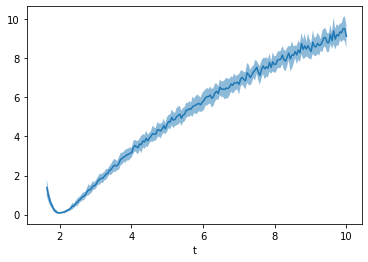

In [ ]:
m = np.mean(L, axis=0)
s = np.std(L, axis=0)

plt.plot(ts, m)
plt.fill_between(ts, m-s, m+s, alpha=0.5)
plt.xlabel("t")
plt.show()

#### Test Gaussian Distributions

In [56]:
n_samples = 500

mean0 = np.eye(2)
sigma0 = 1

mean1 = generate_random_spd_matrix(2)
sigma1 = 1

random_state = 42

samples0 = torch.tensor(sample_gaussian_spd(n_matrices=500, mean=mean0, sigma=sigma0, random_state=random_state), device=device)
samples1 = torch.tensor(sample_gaussian_spd(n_matrices=500, mean=mean1, sigma=sigma1, random_state=random_state), device=device)

In [57]:
sliced_wasserstein_spd(samples0, samples1, 500, device=device).item()

0.8898672887284991

In [58]:
theta = np.random.normal(size=(1, 2))
theta = F.normalize(torch.from_numpy(theta), p=2, dim=-1).to(device)

A = theta[:,None] * torch.eye(theta.shape[-1], device=device)

## Preprocessing to compute the matrix product using a simple product
# diagA = torch.diagonal(A, dim1=-2, dim2=-1)

In [59]:
A

tensor([[[ 0.6456, -0.0000],
         [ 0.0000, -0.7637]]], device='cuda:0', dtype=torch.float64)

In [60]:
ntry = 10
nsamples = 250
nprojs = 500

ts = torch.linspace(-10,10,100)
L_sw_gaussians = np.zeros((ntry, len(ts)))


mean0 = np.eye(2)
sigma0 = 1
sigma1 = 1

bar = trange(ntry)
for k in bar:
    pbar = range(len(ts))

    for i in pbar:
        t = ts[i]
        
        mean1 = torch.linalg.matrix_exp(t*A[0]).cpu().numpy()

        ## Slow as not implemented on pytorch
        B0 = torch.tensor(sample_gaussian_spd(n_matrices=nsamples, mean=mean0, sigma=sigma0), device=device)
        Bt = torch.tensor(sample_gaussian_spd(n_matrices=nsamples, mean=mean1, sigma=sigma1), device=device)
        
        sw = sliced_wasserstein_spd(B0, Bt, nprojs, device=device).item()
        L_sw_gaussians[k, i] = sw
    

  0%|          | 0/10 [00:00<?, ?it/s]

In [61]:
np.savetxt("./SPDSW_Gaussians.csv", L_sw_gaussians, delimiter=",")

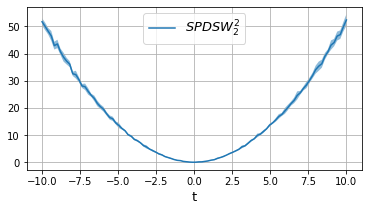

In [62]:
m = np.mean(L_sw_gaussians, axis=0)
s = np.std(L_sw_gaussians, axis=0)

plt.figure(figsize=(6,3))
plt.plot(ts, m, label=r"$SPDSW_2^2$")
plt.fill_between(ts, m-s, m+s, alpha=0.5)
plt.xlabel("t", fontsize=13)
# plt.title(r"$SWSPD_2^2$", fontsize=13)
plt.legend(fontsize=13)
plt.grid(True)
plt.savefig("./SW_Gaussians.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [63]:
manifold = geoopt.SymmetricPositiveDefinite()

In [64]:
ntry = 10
nsamples = 250
nprojs = 500

ts = torch.linspace(-10,10,100)
L_w_gaussians = np.zeros((ntry, len(ts)))


mean0 = np.eye(2)
sigma0 = 1
sigma1 = 1

bar = trange(ntry)
for k in bar:
    pbar = range(len(ts))

    for i in pbar:
        t = ts[i]
        
        mean1 = torch.linalg.matrix_exp(t*A[0]).cpu().numpy()

        ## Slow as not implemented on pytorch
        B0 = torch.tensor(sample_gaussian_spd(n_matrices=nsamples, mean=mean0, sigma=sigma0), device=device)
        Bt = torch.tensor(sample_gaussian_spd(n_matrices=nsamples, mean=mean1, sigma=sigma1), device=device)
        
        a = torch.ones((nsamples,), device=device, dtype=torch.float64)/nsamples
        b = torch.ones((nsamples,), device=device, dtype=torch.float64)/nsamples

        M = manifold.dist(B0[:,None], Bt[None])**2

        w = ot.emd2(a, b, M)
        L_w_gaussians[k, i] = w.item()
    

  0%|          | 0/10 [00:00<?, ?it/s]

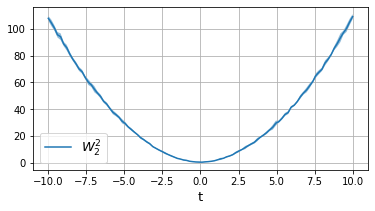

In [65]:
m = np.mean(L_w_gaussians, axis=0)
s = np.std(L_w_gaussians, axis=0)

plt.figure(figsize=(6,3))
plt.plot(ts, m, label=r"$W_2^2$")
plt.fill_between(ts, m-s, m+s, alpha=0.5)
plt.xlabel("t", fontsize=13)
# plt.title(r"$SWSPD_2^2$", fontsize=13)
plt.legend(fontsize=13)
plt.grid(True)
plt.savefig("./W_Gaussians.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [67]:
np.savetxt("./W_Gaussians.csv", L_w_gaussians, delimiter=",")

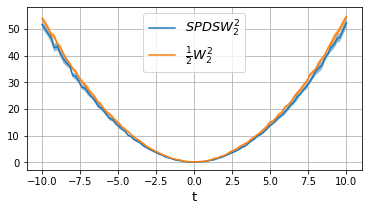

In [68]:
m = np.mean(L_sw_gaussians, axis=0)
s = np.std(L_sw_gaussians, axis=0)

plt.figure(figsize=(6,3))
plt.plot(ts, m, label=r"$SPDSW_2^2$")
plt.fill_between(ts, m-s, m+s, alpha=0.5)


m = np.mean(L_w_gaussians/2, axis=0)
s = np.std(L_w_gaussians/2, axis=0)

plt.plot(ts, m, label=r"$\frac{1}{2} W_2^2$")
plt.fill_between(ts, m-s, m+s, alpha=0.5)

plt.xlabel("t", fontsize=13)
plt.legend(fontsize=13)
plt.grid(True)
plt.savefig("./SW_vs_W_Gaussians.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Wasserstein Distance

Seems to be difficulties to compute the distance when the matrices are ill conditioned. However, seems to not be a problem for SW?

In [69]:
manifold = geoopt.SymmetricPositiveDefinite()

In [70]:
def dist_spd(A,B):
    A_ = torch.linalg.inv(A)
    C = torch.matmul(A_[:,None], B[None])
    
    # log_C = torch.zeros(C.shape, device=C.device)
    # for i in range(log_C.shape[0]):
    #     for j in range(log_C.shape[1]):
    #         log = logm(C[i,j])
    #         log_C[i,j] = log@log

    log_C = linalg.sym_logm(C)
    # log_C2 = torch.matmul(log_C, log_C)

    # tr = log_C.diagonal(offset=0, dim1=-1, dim2=-2).sum(-1)
    # return tr**(1/2)
    return torch.linalg.matrix_norm(log_C)

In [ ]:
ts = torch.linspace(0.1,10,100)
L = np.zeros((20,100))

for k in range(20):
    pbar = trange(len(ts))
#     pbar = range(len(ts))
    for i in pbar:
        t = ts[i]
        mt = D.Wishart(torch.tensor([2], dtype=torch.float64).to(device), t*torch.eye(2, dtype=torch.float64, device=device))
        B0 = m0.sample((500,))[:,0]
        Bt = mt.sample((500,))[:,0]

        a = torch.ones((500,), device=device, dtype=torch.float64)/500
        b = torch.ones((500,), device=device, dtype=torch.float64)/500
        
        # M = dist_spd(B0, Bt)**2
        M = manifold.dist(B0[:,None], Bt[None])**2

        # print(a.shape, b.shape, M.shape)

        w = ot.emd2(a, b, M)
        L[k, i] = w.item()

        if torch.isnan(w):
            print(torch.any(torch.isnan(M)))
            # print(M)

            idx = torch.nonzero(torch.isnan(M))
            print(idx)
            print(M[idx[0,0], idx[0,1]])
            print(B0[idx[0,0]], Bt[idx[0,1]])
            break
    break

  0%|          | 0/100 [00:00<?, ?it/s]

tensor(True, device='cuda:0')
tensor([[458, 218]], device='cuda:0')
tensor(nan, device='cuda:0', dtype=torch.float64)
tensor([[0.1471, 0.2344],
        [0.2344, 0.3734]], device='cuda:0', dtype=torch.float64) tensor([[3.1119, 0.4020],
        [0.4020, 0.0519]], device='cuda:0', dtype=torch.float64)


In [ ]:
A_ = torch.linalg.inv(B0[idx[0,0]])
A_

tensor([[ 4.6144e+08, -2.8960e+08],
        [-2.8960e+08,  1.8175e+08]], device='cuda:0', dtype=torch.float64)

In [ ]:
C = torch.matmul(A_, Bt[idx[0,1]])
C

tensor([[ 1.3195e+09,  1.7044e+08],
        [-8.2812e+08, -1.0697e+08]], device='cuda:0', dtype=torch.float64)

In [ ]:
linalg.sym_logm(C)

tensor([[nan, nan],
        [nan, nan]], device='cuda:0', dtype=torch.float64)

In [ ]:
manifold.dist(B0[idx[0,0]], Bt[idx[0,1]])

tensor(nan, device='cuda:0', dtype=torch.float64)

In [ ]:
sliced_wasserstein_spd(B0, Bt, 500, device).item()

0.19461732514043417

In [71]:
ts = torch.linspace(0.1,10,100)
L_w_wishart = np.zeros((20,100))

for k in range(20):
    pbar = trange(len(ts))
#     pbar = range(len(ts))
    for i in pbar:
        t = ts[i]
        mt = D.Wishart(torch.tensor([2], dtype=torch.float64).to(device), t*torch.eye(2, dtype=torch.float64, device=device))
        B0 = m0.sample((500,))[:,0]
        Bt = mt.sample((500,))[:,0]

        a = torch.ones((500,), device=device, dtype=torch.float64)/500
        b = torch.ones((500,), device=device, dtype=torch.float64)/500
        
        # M = dist_spd(B0, Bt)**2
        M = manifold.dist(B0[:,None], Bt[None])**2

        # print(a.shape, b.shape, M.shape)

        w = ot.emd2(a, b, M)
        L_w_wishart[k, i] = w.item()

    #     if torch.isnan(w):
    #         print(torch.any(torch.isnan(M)))
    #         # print(M)

    #         idx = torch.nonzero(torch.isnan(M))
    #         print(idx)
    #         print(M[idx[0,0], idx[0,1]])
    #         print(B0[idx[0,0]], Bt[idx[0,1]])
    #         break
    # break

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/distributions/wishart.py:247: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

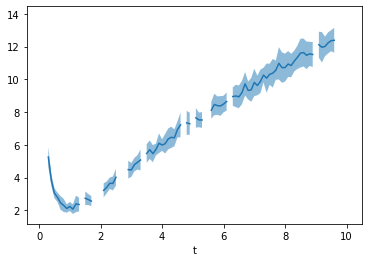

In [72]:
m = np.mean(L_w_wishart, axis=0)
s = np.std(L_w_wishart, axis=0)

plt.plot(ts, m)
plt.fill_between(ts, m-s, m+s, alpha=0.5)
plt.xlabel("t")
plt.show()

In [84]:
L_sw_wishart.shape

(20, 100)

In [85]:
L_w_wishart.shape

(20, 100)

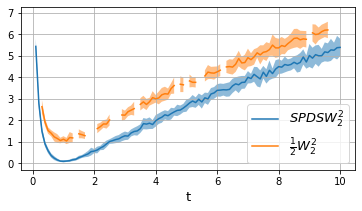

In [86]:
m = np.mean(L_sw_wishart, axis=0)
s = np.std(L_sw_wishart, axis=0)

plt.figure(figsize=(6,3))
plt.plot(ts, m, label=r"$SPDSW_2^2$")
plt.fill_between(ts, m-s, m+s, alpha=0.5)


m = np.mean(L_w_wishart/2, axis=0)
s = np.std(L_w_wishart/2, axis=0)

plt.plot(ts, m, label=r"$\frac{1}{2} W_2^2$")
plt.fill_between(ts, m-s, m+s, alpha=0.5)

plt.xlabel("t", fontsize=13)
plt.legend(fontsize=13)
plt.grid(True)
plt.savefig("./SW_vs_W_Wishart.pdf", format="pdf", bbox_inches="tight")
plt.show()

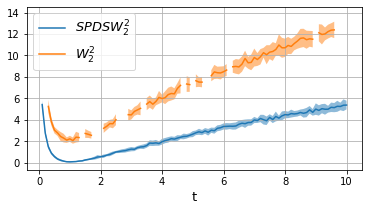

In [88]:
m = np.mean(L_sw_wishart, axis=0)
s = np.std(L_sw_wishart, axis=0)

plt.figure(figsize=(6,3))
plt.plot(ts, m, label=r"$SPDSW_2^2$")
plt.fill_between(ts, m-s, m+s, alpha=0.5)


m = np.mean(L_w_wishart, axis=0)
s = np.std(L_w_wishart, axis=0)

plt.plot(ts, m, label=r"$W_2^2$")
plt.fill_between(ts, m-s, m+s, alpha=0.5)

plt.xlabel("t", fontsize=13)
plt.legend(fontsize=13)
plt.grid(True)
# plt.savefig("./SW_vs_W_Wishart.pdf", format="pdf", bbox_inches="tight")
plt.show()

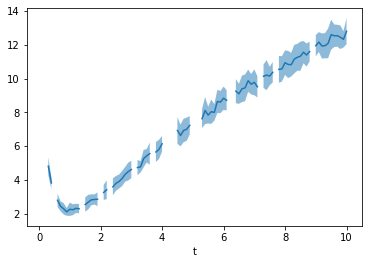

In [ ]:
m = np.mean(L, axis=0)
s = np.std(L, axis=0)

plt.plot(ts, m)
plt.fill_between(ts, m-s, m+s, alpha=0.5)
plt.xlabel("t")
plt.show()

### Gradient Flows

In [9]:
manifold = geoopt.SymmetricPositiveDefinite()

In [14]:
from geoopt.optim import RiemannianSGD, RiemannianAdam
from torch.utils.data import DataLoader
from itertools import cycle

In [52]:
mean_target = generate_random_spd_matrix(2)
sigma_target = 0.1

X_target = torch.tensor(sample_gaussian_spd(n_matrices=10000, mean=mean_target, sigma=sigma_target), device=device)

train_dl = DataLoader(X_target, batch_size=500, shuffle=True)
dataiter = iter(cycle(train_dl))

In [64]:
x_sw = manifold.random((500,2,2)).to(device)
x_sw.requires_grad_(True)

optimizer_sw = RiemannianSGD([x_sw], lr=2)
optimizer_sw._default_manifold = manifold

In [65]:
n_epochs = 1000
nprojs = 500

pbar = trange(n_epochs)

L_sw = np.zeros((1,n_epochs))
L_loss = []

k = 0

for e in pbar:
    optimizer_sw.zero_grad()
    X_target = next(dataiter).type(torch.float).to(device)

    sw = sliced_wasserstein_spd(x_sw, X_target, nprojs, device=device)
    sw.backward()
    optimizer_sw.step()

    L_loss.append(sw.item())
    pbar.set_postfix_str(f"loss = {sw.item():.3f}")


    # if torch.any(torch.isinf(x_sw)):
    #     L_sw[k, e] = np.inf
    # else:
    #     x_test = torch.tensor(sample_gaussian_spd(n_matrices=500, mean=mean_target, sigma=sigma_target), device=device).type(torch.float)

    #     a = torch.ones((500,), device=device, dtype=torch.float32)/500
    #     b = torch.ones((500,), device=device, dtype=torch.float32)/500

    #     M = manifold.dist(x_sw[:,None], x_test[None])**2
    #     w_sw = ot.emd2(a, b, M)
    #     L_sw[k, e] = w_sw.item()

  0%|          | 0/1000 [00:00<?, ?it/s]

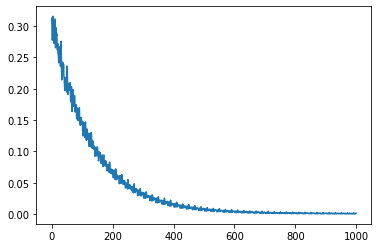

In [66]:
plt.plot(L_loss)
plt.show()

In [70]:
x_sw = manifold.random((500,2,2)).to(device)
x_sw.requires_grad_(True)

optimizer_sw = RiemannianSGD([x_sw], lr=2)
optimizer_sw._default_manifold = manifold

In [71]:
n_epochs = 1000
nprojs = 500

pbar = trange(n_epochs)

L_sw = np.zeros((1,n_epochs))
L_loss = []

k = 0

for e in pbar:
    optimizer_sw.zero_grad()
    X_target = next(dataiter).type(torch.float).to(device)

    sw = sliced_wasserstein_spd(x_sw, X_target, nprojs, device=device)
    sw.backward()
    optimizer_sw.step()

    L_loss.append(sw.item())
    pbar.set_postfix_str(f"loss = {sw.item():.3f}")


    if torch.any(torch.isinf(x_sw)):
        L_sw[k, e] = np.inf
    else:
        # x_test = torch.tensor(sample_gaussian_spd(n_matrices=500, mean=mean_target, sigma=sigma_target), device=device).type(torch.float)
        x_test = X_target

        a = torch.ones((500,), device=device, dtype=torch.float32)/500
        b = torch.ones((500,), device=device, dtype=torch.float32)/500

        M = manifold.dist(x_sw[:,None], x_test[None])**2
        w_sw = ot.emd2(a, b, M)
        L_sw[k, e] = w_sw.item()

  0%|          | 0/1000 [00:00<?, ?it/s]

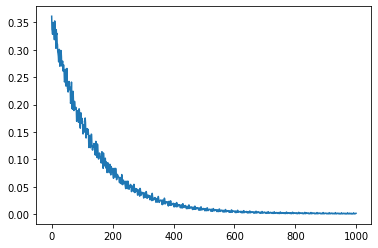

In [72]:
plt.plot(L_loss)
plt.show()

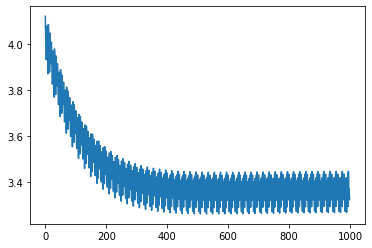

In [73]:
plt.plot(L_sw[0])
plt.show()